In [ ]:
# Gerekli kütüphaneleri indiriyoruz
!pip install ultralytics easyocr transformers torch torchvision opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 11.3 MB/s eta 0:00:00


In [ ]:
import cv2
import easyocr
import torch
from ultralytics import YOLO
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Cihazı kesin olarak CPU yapıyoruz. Eğer colab aboneliğiniz var ise GPU seçerek daha hızlı çalışmasını sağlayabilirsiniz.
device = "cpu"
print(f"⚙️ Çalışma Modu: {device.upper()} (GPU kullanılmayacak)")

# 1. YOLOv8 Modelini Yükle
print("1. YOLO yükleniyor...")
yolo_model = YOLO('yolov8n.pt')

# 2. EasyOCR Reader'ı Başlat (GPU Kapalı)
print("2. EasyOCR hazırlanıyor...")
reader = easyocr.Reader(['en'], gpu=False) # BURASI DEĞİŞTİ

# 3. VLM Modelini Yükle (Salesforce BLIP)
print("3. VLM (Blip) yükleniyor...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# Modeli CPU'ya yüklüyoruz
vlm_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)

print("✅ Tüm modeller CPU modunda başarıyla yüklendi!")

⚙️ Çalışma Modu: CPU (GPU kullanılmayacak)
1. YOLO yükleniyor...
2. EasyOCR hazırlanıyor...
3. VLM (Blip) yükleniyor...
✅ Tüm modeller CPU modunda başarıyla yüklendi!


In [ ]:
def analyze_vehicle(image_path, whitelist):
    img = cv2.imread(image_path)
    # Görüntü yüklenemezse hata vermesin diye kontrol
    if img is None:
        return None, "Dosya okunamadı. Lütfen geçerli bir resim yükleyin."

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_image = Image.open(image_path).convert('RGB')

    # A. ARAÇ TESPİTİ (YOLOv8)
    # device='cpu' parametresi ile çalıştırıyoruz
    results = yolo_model(img, classes=[2, 7], verbose=False, device='cpu')

    # Eğer hiç araç bulunamazsa
    if len(results[0].boxes) == 0:
        return None, "Görselde araç tespit edilemedi."

    # En büyük güven skoruna sahip aracı alalım
    box = results[0].boxes[0]
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls = int(box.cls[0])

    vehicle_type = "TIR/KAMYON" if cls == 7 else "ARABA"

    vehicle_crop = img[y1:y2, x1:x2]
    vehicle_crop_pil = Image.fromarray(cv2.cvtColor(vehicle_crop, cv2.COLOR_BGR2RGB))

    # B. PLAKA OKUMA (EasyOCR)
    # EasyOCR zaten yukarıda gpu=False olarak ayarlandığı için direkt çağırıyoruz
    ocr_results = reader.readtext(vehicle_crop)

    detected_plate = "OKUNAMADI"
    access_status = "REDDEDİLDİ"
    color = (255, 0, 0) # Kırmızı

    for (bbox, text, prob) in ocr_results:
        clean_text = ''.join(e for e in text if e.isalnum()).upper()
        if len(clean_text) > 4 and prob > 0.4:
            detected_plate = clean_text
            if detected_plate in whitelist:
                access_status = "ONAYLANDI"
                color = (0, 255, 0) # Yeşil
            break

    #C. VLM YORUMLAMA (BLIP)
    text_prompt = "a photo of a vehicle"
    # BURASI ÖNEMLİ: inputları da CPU'ya gönderiyoruz (.to(device))
    inputs = processor(vehicle_crop_pil, text_prompt, return_tensors="pt").to(device)

    out = vlm_model.generate(**inputs, max_new_tokens=50)
    vlm_comment = processor.decode(out[0], skip_special_tokens=True)

    #D. GÖRSELLEŞTİRME
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 3)
    info_text = f"{vehicle_type} | {detected_plate}"
    # Metni resmin içine sığdırmak için konum ayarı
    text_y = y1 - 10 if y1 - 10 > 10 else y1 + 20
    cv2.putText(img_rgb, info_text, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    return img_rgb, {
        "type": vehicle_type,
        "plate": detected_plate,
        "status": access_status,
        "vlm_comment": vlm_comment
    }

Lütfen analiz edilecek görselleri yükleyin...


Saving araba1.png to araba1.png
Saving araba2.png to araba2.png
Saving tır.png to tır (1).png

>>> araba1.png Analiz Ediliyor...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Araç Tipi: ARABA
Okunan Plaka: 16BZC729
Erişim Durumu: ONAYLANDI
Yapay Zeka Yorumu: a photo of a vehicle parked in a parking lot with a license plate
------------------------------

>>> araba2.png Analiz Ediliyor...
Araç Tipi: ARABA
Okunan Plaka: OKUNAMADI
Erişim Durumu: REDDEDİLDİ
Yapay Zeka Yorumu: a photo of a vehicle parked in a parking lot with a sky reflection on the windshield
------------------------------

>>> tır (1).png Analiz Ediliyor...
Araç Tipi: TIR/KAMYON
Okunan Plaka: OKUNAMADI
Erişim Durumu: REDDEDİLDİ
Yapay Zeka Yorumu: a photo of a vehicle driving down a road with a mountain in the background
------------------------------


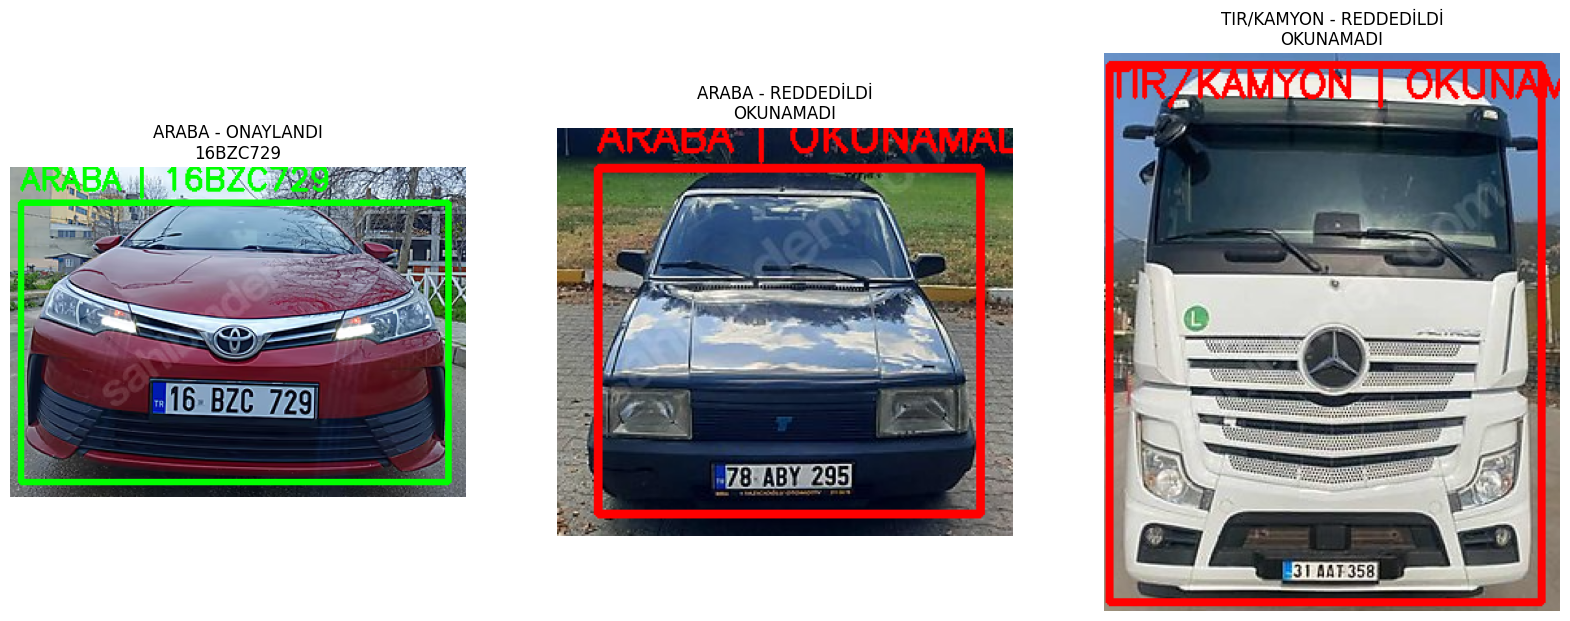

In [ ]:
# AYARLAR
# İzin verilecek plakayı Whitelist'e alıyoruz.
WHITELIST = ["16BZC729"]

print("Lütfen analiz edilecek görselleri yükleyin...")
uploaded = files.upload()

plt.figure(figsize=(20, 10))

for i, filename in enumerate(uploaded.keys()):
    print(f"\n>>> {filename} Analiz Ediliyor...")

    # Fonksiyonu çalıştır
    result_img, data = analyze_vehicle(filename, WHITELIST)

    if data:
        print(f"Araç Tipi: {data['type']}")
        print(f"Okunan Plaka: {data['plate']}")
        print(f"Erişim Durumu: {data['status']}")
        print(f"Yapay Zeka Yorumu: {data['vlm_comment']}")
        print("-" * 30)

        # Görseli göster
        plt.subplot(1, len(uploaded), i+1)
        plt.imshow(result_img)
        plt.title(f"{data['type']} - {data['status']}\n{data['plate']}")
        plt.axis('off')
    else:
        print("Hata:", data)

plt.show()